In [1]:
import numpy as np
import pymc3 as pm

import pandas as pd
from scipy.special import logit, expit

import matplotlib.pyplot as plt

In [2]:
scores = np.concatenate([np.load(f'../processed_data/D4_all{i}.npy') for i in range(10)])

In [3]:
df = pd.read_csv('../data/41586_2019_917_MOESM4_ESM.csv')

In [4]:
#these are the docking scores:
df['Energy'] = np.array(df['Energy'].str.strip('¶')).astype(float)

#set the "not determined" records to zero inhibition:
df.loc[df['Inhibition (%) at 10uM'].str.contains('ND'), 'Inhibition (%) at 10uM'] = 0


In [5]:
#this simply uses argsort (twice) to find the 1-indexed rank of each score, including
#the ligands used in _in vitro_ validation. Ranks are then normalized by dividing by 
#number of items

normalized_ranks = ( (np.concatenate([scores, df['Energy']]).argsort().argsort()+1) /\
                ((scores.shape[0]+df['Energy'].shape[0]) - 1) )

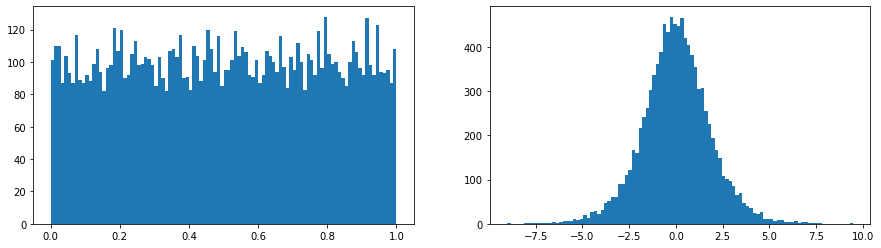

In [7]:
#we can see that the logit(normalized_ranks) are normally distrubuted, 
#which is what you would expect when logit-transforming a uniformly-distributed

fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)

_ = ax[0].hist(np.random.choice(normalized_ranks, 10000), bins=100)
_ = ax[1].hist(logit(np.random.choice(normalized_ranks, 10000)), bins=100)

In [8]:
#this holds the ranks of the in vitro tested molecules:
ranks = normalized_ranks[-df['Energy'].shape[0]:]

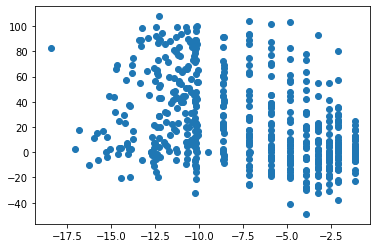

In [9]:
#observe that this resembles Lyu et al, except the points at the bottom of the 
#curve are bunched a bit closer. This more accurately represents
#where the tested range sits in comparison to the rest of the distribution.


plt.scatter(logit(ranks), df['Inhibition (%) at 10uM'].values.astype(float))

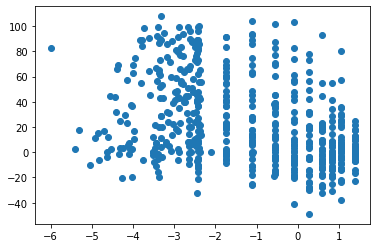

In [151]:
plt.scatter(np.log10(ranks*100), df['Inhibition (%) at 10uM'].values.astype(float))

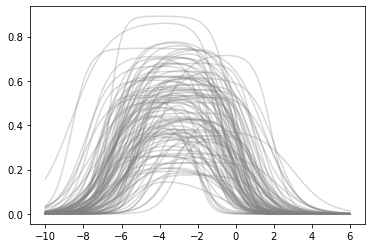

In [130]:
#sigmoid 1 = 
middle1 = norm(0, 1)
slope1 = halfnorm(0, 1)
height1 = beta(5, 2)

#sigmoid 2 = 
middle2 = norm(-6, 1)
slope2 = halfnorm(0,1)
height2 = beta(5,2)

x = np.linspace(-10, 6, 100)

for i in range(100):
    _middle1 = middle1.rvs()
    _slope1 = slope1.rvs()+1
    _height1 = height1.rvs()
    
    _middle2 = middle2.rvs()
    _slope2 = slope2.rvs()+1
    _height2 = height2.rvs()
    
  
    
    _sigmoid1 = _height1 / (1 + np.exp(_slope1*(x - _middle1)))
    
    _sigmoid2 = _height2 / (1 + np.exp(-_slope2*(x - _middle2)))
    
    plt.plot(x, _sigmoid1* _sigmoid2, c='grey', alpha=0.3)

In [162]:
with pm.Model() as model:
    #three parameters for the sigmoid:
    middle1 = pm.Normal('middle1', mu=1, sigma=1)
    slope1 = pm.HalfNormal('slope1', sigma=3)
    height1 = pm.Beta('height1', 2,5)
    
    middle2 = pm.Normal('middle2', mu=-4, sigma=2)
    slope2 = pm.HalfNormal('slope2', sigma=3)
    height2 = pm.Beta('height2', 2,2)

    #curve:
    sigmoid1 = pm.Deterministic('sigmoid1', 
                                 height1 / (1 + np.exp(slope1*(np.log10(ranks*100) - middle1)))
                                 )
    sigmoid2 = pm.Deterministic('sigmoid2', 
                                 height2 / (1 + np.exp(-slope2*(np.log10(ranks*100) - middle2)))
                                 )

    #likelihood
    observed = pm.Bernoulli('hits', p=sigmoid1*sigmoid2, observed=hits)
    
    trace = pm.sample(10_000, tune=3000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [height2, slope2, middle2, height1, slope1, middle1]


Sampling 4 chains for 3_000 tune and 10_000 draw iterations (12_000 + 40_000 draws total) took 62 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


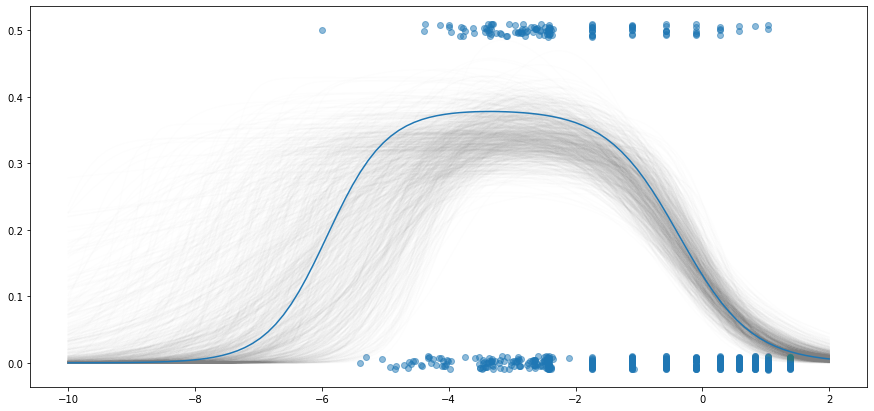

In [163]:
plt.figure(figsize=(15, 7))

x = np.linspace(-10, 2, 100)
for i in range(1000):
    idx = np.random.choice(len(trace['middle1']))
    _middle1 = trace['middle1'][idx]
    _slope1 = trace['slope1'][idx]
    _height1 = trace['height1'][idx]
    _middle2 = trace['middle2'][idx]
    _slope2 = trace['slope2'][idx]
    _height2 = trace['height2'][idx]
    

    _sigmoid1 = _height1 / (1 + np.exp(_slope1*(x - _middle1)))
    
    _sigmoid2 = _height2 / (1 + np.exp(-_slope2*(x - _middle2)))
    
    #plt.plot(x, _sigmoid1, c='grey', alpha=0.3)
    #plt.plot(x, _sigmoid2, c='grey', alpha=0.3)
    plt.plot(x, _sigmoid2*_sigmoid1, c='grey', alpha=0.01)
    
_middle1 = trace['middle1'].mean()
_slope1 = trace['slope1'].mean()
_height1 = trace['height1'].mean()
_middle2 = trace['middle2'].mean()
_slope2 = trace['slope2'].mean()
_height2 = trace['height2'].mean()

_sigmoid1 = _height1 / (1 + np.exp(_slope1*(x - _middle1)))
    
_sigmoid2 = _height2 / (1 + np.exp(-_slope2*(x - _middle2)))
plt.plot(x, _sigmoid2*_sigmoid1, c='C0')

plt.scatter(np.log10(ranks*100), 
            (df['Inhibition (%) at 10uM'].values.astype(float)>50) / 2 + \
            np.random.uniform(-0.01, 0.01, len(ranks)),
           alpha=0.5)

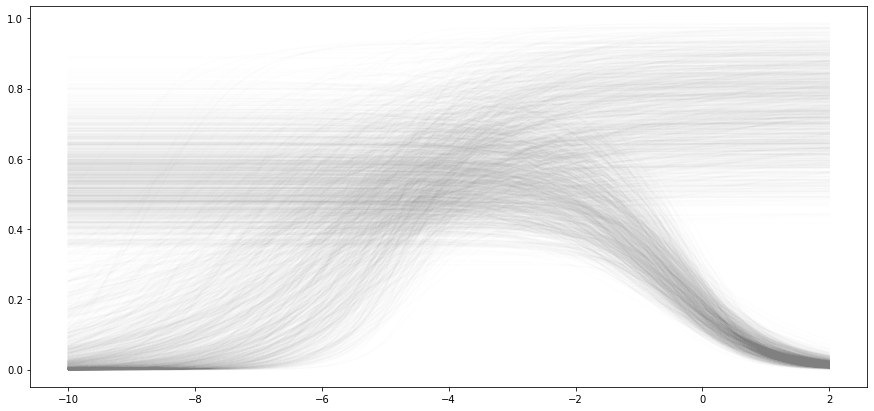

In [157]:
plt.figure(figsize=(15, 7))

x = np.linspace(-10, 2, 100)
for i in range(1000):
    idx = np.random.choice(len(trace['middle1']))
    _middle1 = trace['middle1'][idx]
    _slope1 = trace['slope1'][idx]
    _height1 = trace['height1'][idx]
    _middle2 = trace['middle2'][idx]
    _slope2 = trace['slope2'][idx]
    _height2 = trace['height2'][idx]
    

    _sigmoid1 = _height1 / (1 + np.exp(_slope1*(x - _middle1)))
    
    _sigmoid2 = _height2 / (1 + np.exp(-_slope2*(x - _middle2)))
    
    plt.plot(x, _sigmoid1, c='grey', alpha=0.01)
    plt.plot(x, _sigmoid2, c='grey', alpha=0.01)
    #plt.plot(x, _sigmoid2*_sigmoid1, c='grey', alpha=0.01)

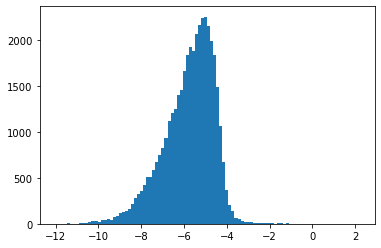

In [160]:
_=plt.hist(trace['middle2'], bins=100)

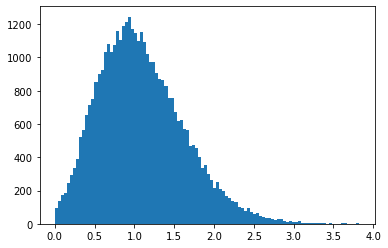

In [161]:
_=plt.hist(trace['slope2'], bins=100)

In [207]:
logit_nranks = logit(ranks)
hits = df['Inhibition (%) at 10uM'].values.astype(float)>50



with pm.Model() as model:
    #three parameters for the sigmoid:
    middle = pm.Normal('middle', mu=0, sigma=1)
    slope = pm.HalfNormal('slope', sigma=6)
    height = pm.Beta('height', 2,5)
    #two parameters for the 'gaussian'
    mu = pm.Normal('mu', mu=-3, sigma=2)
    sig = pm.HalfNormal('sig', sigma=4)
    gheight = pm.Beta('gheight', 2,10 )
    
    #curve:
    gaussian = pm.Deterministic('gaussian', 
                                 gheight/sig * np.exp(- ( (np.log10(ranks)-mu)/sig )**2 ), 
                                 )
    sigmoid = pm.Deterministic('sigmoid', 
                                 height / (1 + np.exp(slope*(np.log10(ranks) + middle)))
                                 )

    #likelihood
    observed = pm.Bernoulli('hits', p=gaussian + sigmoid, observed=hits)
    
    trace = pm.sample(20_000, tune=3000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gheight, sig, mu, height, slope, middle]


Sampling 4 chains for 3_000 tune and 20_000 draw iterations (12_000 + 80_000 draws total) took 77 seconds.
There were 386 divergences after tuning. Increase `target_accept` or reparameterize.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8393851112966065, but should be close to 0.9. Try to increase the number of tuning steps.
There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
There were 379 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


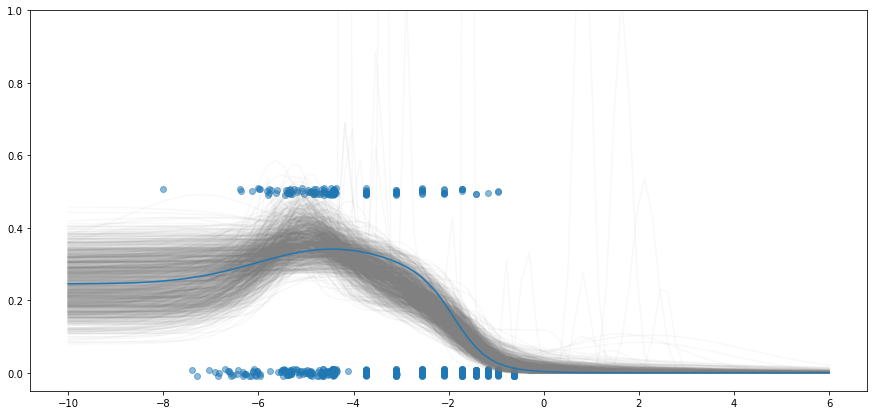

In [209]:
plt.figure(figsize=(15, 7))
for i in range(1000):
    idx = np.random.choice(len(trace['middle']))
    _middle = trace['middle'][idx]
    _slope = trace['slope'][idx]
    _height = trace['height'][idx]
    
    _gheight = trace['gheight'][idx]
    _mu = trace['mu'][idx]
    _sig = trace['sig'][idx]
    
    _gaussian = _gheight/ _sig * np.exp(-((x-_mu)/_sig)**2)
    
    _sigmoid = _height / (1 + np.exp(_slope*(x + _middle)))
    
    plt.plot(x, _gaussian + _sigmoid, c='grey', alpha=0.05)
    
_middle = trace['middle'].mean()
_slope = trace['slope'].mean()
_height = trace['height'].mean()
_gheight = trace['gheight'].mean()
_mu = trace['mu'].mean()
_sig = trace['sig'].mean()

_gaussian = _gheight/ _sig * np.exp(-((x-_mu)/_sig)**2)
    
_sigmoid = _height / (1 + np.exp(_slope*(x + _middle)))
plt.plot(x, _gaussian + _sigmoid, c='C0', alpha=1)
plt.ylim(-0.05,1)
plt.scatter(np.log10(ranks), 
            (df['Inhibition (%) at 10uM'].values.astype(float)>50) / 2 + \
            np.random.uniform(-0.01, 0.01, len(ranks)),
           alpha=0.5)

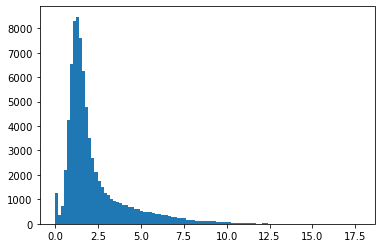

In [212]:
_ = plt.hist(trace['sig'], bins=100)

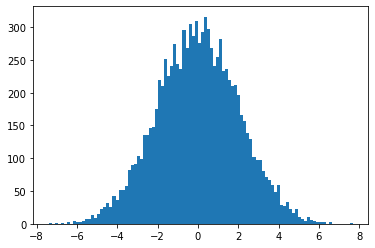

In [206]:
_ = plt.hist(norm(0, 2).rvs(10000), bins=100)

In [32]:
from scipy.stats import norm, halfnorm, beta

middle = norm(0, 10)
slope = norm(0, 6)
height = beta(2, 2)

mu = norm(3, 2)
sig = halfnorm(6)

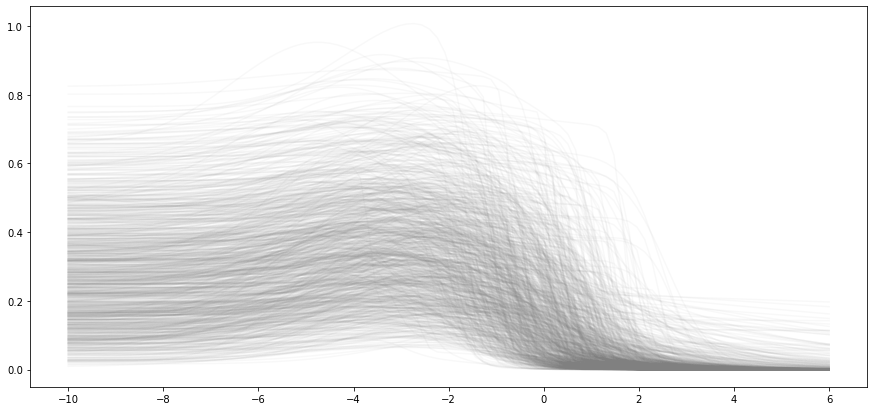

In [175]:
plt.figure(figsize=(15, 7))

middle = norm(0, 1)
slope = halfnorm(0, 6)
height = beta(2, 5)

gheight = beta(2, )
mu = norm(-3, 1)
sig = halfnorm(2)

x = np.linspace(-10, 6, 100)

for i in range(1000):
    _middle = middle.rvs()
    _slope = slope.rvs()
    _height = height.rvs()
    _mu = mu.rvs()
    _sig = sig.rvs()
    _gheight= gheight.rvs()
    
    _gaussian = _gheight/ _sig * np.exp(-((x-_mu)/_sig)**2)
    
    _sigmoid = _height / (1 + np.exp(_slope*(x + _middle)))
    
    plt.plot(x, _gaussian + _sigmoid, c='grey', alpha=0.05)
    #plt.plot(x, _gaussian , c='grey', alpha=0.05)
    #plt.plot(x, _sigmoid , c='grey', alpha=0.3)

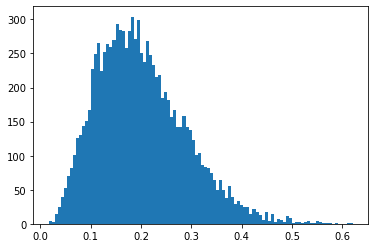

In [177]:
_ = plt.hist(beta(4,16).rvs(10000), bins=100)

(array([2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 2., 5.,
        0., 1., 0., 0., 1., 2., 2., 2., 0., 1., 0., 3., 1., 1., 1., 1., 5.,
        5., 4., 1., 3., 2., 1., 1., 3., 3., 4., 0., 1., 2., 1., 1., 1., 4.,
        3., 2., 2., 1., 1., 5., 2., 0., 0., 1., 1., 1., 0., 2., 0., 0., 1.,
        0., 1., 0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-0.93029008, -0.83022047, -0.73015086, -0.63008125, -0.53001164,
        -0.42994202, -0.32987241, -0.2298028 , -0.12973319, -0.02966357,
         0.07040604,  0.17047565,  0.27054526,  0.37061488,  0.47068449,
         0.5707541 ,  0.67082371,  0.77089333,  0.87096294,  0.97103255,
         1.07110216,  1.17117177,  1.27124139,  1.371311  ,  1.47138061,
         1.57145022,  1.67151984,  1.77158945,  1.87165906,  1.97172867,
         2.07179829,  2.1718679 ,  2.27193751,  2.37200712,  2.47207674,
         2.57214635,  2.67221596,  2.77

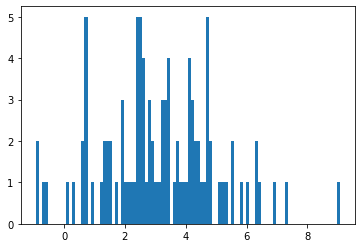

In [44]:
plt.hist(mu.rvs(100), bins=100)

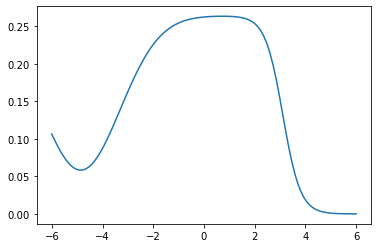

In [29]:
_middle = trace['middle'].mean()
_slope = trace['slope'].mean()
_height = trace['height'].mean()

_mu = trace['mu'].mean()
_sig = trace['sig'].mean()

x = np.linspace(-6, 6, 100)

_gaussian = 1/_sig * np.exp(-(x-_sig)**2/_sig)

sgm = lambda x: 1/(1+np.exp(x))


plt.plot(-x, _height * sgm(_slope*(x+_middle)) - _gaussian)


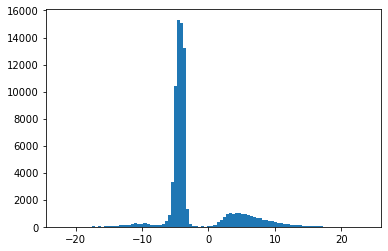

In [30]:
_ = plt.hist(trace['mu'], bins=100)

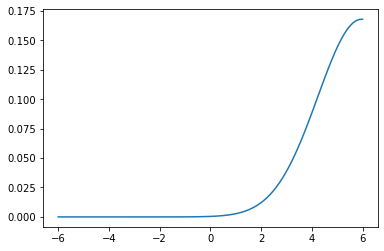

In [25]:
plt.plot(x, _gaussian)

In [10]:
print('Middle HPD:')
print(-pm.stats.hpd(trace['middle']))
print(expit(-pm.stats.hpd(trace['middle']))*100)

Middle HPD:
[-4.16668168 -6.97832459]
[1.52669282 0.09309956]


/home/lewis/miniconda3/envs/dockop/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


In [24]:
expit(-np.mean(trace['middle'])) * 100

0.39416989384309226

In [27]:
np.mean(trace['middle'])

5.532193958057719

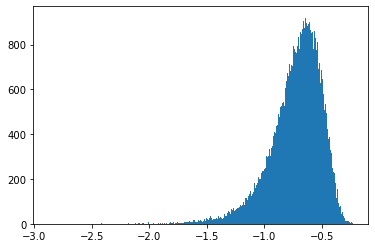

In [11]:
_ =plt.hist(trace['slope'], bins=500)

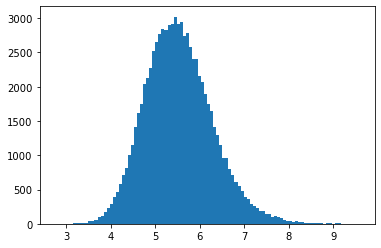

In [12]:
_ =plt.hist(trace['middle'], bins=100)

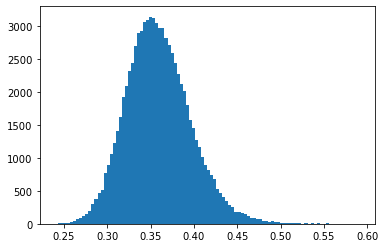

In [13]:
_ = plt.hist(trace['height'],bins=100)

In [44]:
from altair import expr, datum
import altair as alt

x = np.linspace(-16, 2, 100)
line_source = pd.DataFrame({'Score':x})
base = alt.Chart(line_source).mark_line(color='gray', opacity=0.1).encode(
    x = alt.X('Score:Q', title='logit(Rank)'),
    y = alt.Y('Hit rate:Q', title='Hit rate')
)

lines = []
for i in range(300):
    sample_idx = np.random.choice(trace['height'].shape[0])
    height =trace['height'][sample_idx]
    slope = trace['slope'][sample_idx]
    middle = trace['middle'][sample_idx]
    
    lines.append(base.transform_calculate(
        as_='Hit rate', 
        calculate = height * 1/ (1 + expr.exp( - (middle+datum.Score)*slope))
    ))
    
    

hline2 = alt.Chart(line_source).mark_rule(size=0.2, strokeDash=[5, 5]).encode(
    x=alt.X('hline2:Q', title='logit(Rank)'),
)

ch = alt.layer(base, *lines, hline2,).transform_calculate(hline2="-5.5")
ch

alt.LayerChart(...)

In [45]:
ch.save('../figures/hit_rate_vs_rank.html')